In [1]:
import matplotlib.pyplot as plt

(array([0.6757    , 0.        , 0.        , 1.0036    , 0.        ,
        0.        , 0.993     , 0.        , 0.        , 0.66103333]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

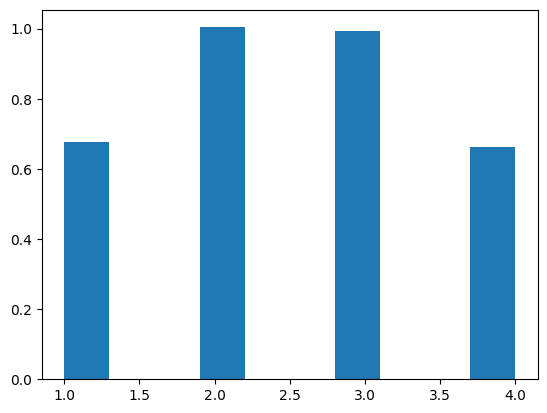

In [2]:
from vose_sampler import VoseAlias
# Example usage
dist = {1: 0.2, 2: 0.3, 3: 0.3, 4: 0.2}
VA = VoseAlias(dist)

# Sample 10 elements
samples = VA.sample_n(size=100000)

# Print the sample (might not reflect the exact probabilities due to randomness)
plt.hist(samples, density=True)


[0 0 1 2 3 4 0 0 0 0 0 1 2 3 5] [1.         0.98867948 0.79444064 0.75448421 0.84736775 0.71596335
 0.98997885 0.9317448  0.8799812  0.8336664  0.79198308 0.7542696
 0.71998462 0.68868094 0.6599859 ]


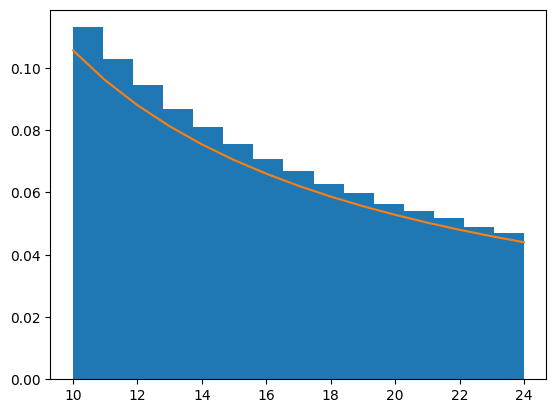

In [3]:
import numpy as np

def build_alias(probas):
    values = np.arange(len(probas)).tolist()
    dist = {v: p for v,p in zip(values, probas.tolist())}
    va = VoseAlias(dist)
    alias = va.table_alias
    thresholds = {k: float(i) for k,i in va.table_prob.items()}
    alias = np.array([(alias[i] if i in alias else i) for i in values])
    thresholds = np.array([(thresholds[i] if i in thresholds else 1.0) for i in values])
    return alias, thresholds


def sample(alias, thr, remap=None, num_samples=1):
    index = np.random.randint(0, len(alias), size=(num_samples))
    unif = np.random.uniform(0,1, size=(num_samples))
    res = np.where(unif > thr[index], alias[index], index)
    if remap is not None:
        return remap[res]

v = np.arange(10, 25)
p = 1 / v # np.ones_like(v).astype(float)
p /= p.sum()



alias, thr = build_alias(p)
print(alias, thr)
plt.hist(sample(alias, thr, v, 1_000_000), bins=len(alias), density=True)
plt.plot(v, p)

In [ ]:
import numpy as np
from vose_sampler import VoseAlias

def manhattan(x1: int, y1: int, x2: int, y2: int) -> int:
    return abs(x1 - x2) + abs(y1 - y2)

def lr_proba(dist, alpha):
    if not isinstance(dist, np.ndarray):
        dist = np.array(dist, dtype=float)
    
    zero_mask = dist <= 1
    result = np.zeros_like(dist)
    result[~zero_mask] = dist[~zero_mask] ** -alpha
    return result

def num_of_distance(n,i):
    assert n % 2 == 1
    diameter = (n-1) // 2
    if i == 0:
        return 1
    if i <= diameter:
        return 4 * i
    z = 2*diameter - i+1
    return 4 * z



def get_probas(n, alpha):
    max_dist = 2*n+1
    values = np.arange(2, max_dist+1)
    probas = lr_proba(values.astype(float), alpha)
    for i in range(2, max_dist+1):
        probas[i-2] *= num_of_distance(n*2+1, i)
    probas /= probas.sum()
    return values, probas

def build_alias(probas):
    values = np.arange(len(probas)).tolist()
    dist = {v: p for v,p in zip(values, probas.tolist())}
    va = VoseAlias(dist)
    alias = va.table_alias
    thresholds = {k: float(i) for k,i in va.table_prob.items()}
    alias = np.array([(alias[i] if i in alias else i) for i in values])
    thresholds = np.array([(thresholds[i] if i in thresholds else 1.0) for i in values])
    return alias, thresholds


def sample(alias, thr, remap=None, num_samples=1):
    index = np.random.randint(0, len(alias), size=(num_samples))
    unif = np.random.uniform(0,1, size=(num_samples))
    res = np.where(unif > thr[index], alias[index], index)
    if remap is not None:
        return remap[res]

v, p = get_probas(1000, 1)



alias, thr = build_alias(p)
print(alias, thr)
plt.hist(sample(alias, thr, v, 1_000_000), bins=len(alias), density=True)
plt.plot(v, p)

In [6]:
import cupy as cp

alias_kernel = cp.RawKernel(r'''
#include <curand_kernel.h>
__device__ int numOfDistance(int n, int d) {
    const int diameter = (n-1) / 2;
    if (d == 0) {
        return 1;
    }
    if (d <= diameter) {
        return 4 * d;
    }
    else {
        int z = 2*diameter - d + 1;
        return 4 * z;
    }
}

__device__ int2 distanceIndex2Offset(int distance, int index, int n) {
    const int num = numOfDistance(n*2+1, distance);
    const int fieldsPerSide = num / 4;
    const int fieldIdx = index / fieldsPerSide;
    const int remainder = index % fieldsPerSide;

    const int minX = max(1, distance - n);
    const int dx = minX + remainder;
    const int dy = distance - dx;

    if (fieldIdx == 0) {
        return make_int2(dx, dy);
    }
    if (fieldIdx == 1) {
        return make_int2(dy, -dx);
    }
    if (fieldIdx == 2) {
        return make_int2(-dx, -dy);
    }
    if (fieldIdx  == 3) {
        return make_int2(-dy, dx);
    }
}

const int ALIAS_OFFSET = 2;

__device__ int sampleAlias(curandState* state, int* alias, float* threshold, int n) {
    int offset = curand(state) % n;
    float alpha = curand_uniform(state);

    if (threshold[offset] < alpha) {
        return alias[offset] + ALIAS_OFFSET;
    } else {
        return offset + ALIAS_OFFSET;
    }
}

__device__ int2 sampleOffsetNaive(curandState* state, int* alias, float* threshold, int n) {
    const int distance = sampleAlias(state, alias, threshold, n);
    const int num = numOfDistance(n*2+1, distance);
    const int index = curand(state) % num;
    return distanceIndex2Offset(distance, index, n);
}

__device__ int2 sampleOffset(curandState* state, int2 current, int* alias, float* threshold, int n) {
    while (true) {
        int2 offset = sampleOffsetNaive(state, alias, threshold, n);
        int x = offset.x + current.x;
        int y = offset.y + current.y;
        if (0 <= x && x < n && 0 <= y && y < n) {
            return make_int2(x,y);
        }
    }
}

__device__ int manhattan(int2 a, int2 b) {
    return abs(a.x - b.x) + abs(a.y - b.y);
}

__device__ int2 step(curandState* state, int2 current, int2 target, int* alias, float* threshold, int n) {
    const int2 lr = sampleOffset(state, current, alias, threshold, n);
    const int lrDistance = manhattan(lr, target);
    const int currDistance = manhattan(current, target);
    if (lrDistance < currDistance - 1) {
        return lr;
    }
    if (current.x < target.x) {
        return make_int2(current.x+1, current.y);
    }
    if (current.x > target.x) {
        return make_int2(current.x-1, current.y);
    }
    if (current.y < target.y) {
        return make_int2(current.x, current.y+1);
    }
    if (current.y > target.y) {
        return make_int2(current.x, current.y-1);
    }
}

__device__ int navigate(curandState* state, int2 start, int2 target, int* alias, float* threshold, int n) {
    int2 current = start;
    int numSteps = 0;
    while (manhattan(current, target) > 0) {
        numSteps += 1;
        current = step(state, current, target, alias, threshold, n);
    }
    return numSteps;
}

extern "C" __global__
void my_fn(int* alias, float* threshold, int* y, int n, int* sx, int* sy, int* tx, int* ty) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    curandState state;
    curand_init(0, tid, 0, &state);

    const int2 start = make_int2(sx[tid], sy[tid]);
    const int2 target = make_int2(tx[tid], ty[tid]);
    y[tid] = navigate(&state, start, target, alias, threshold, n);
}

''', 'my_fn')


K = 1000
ALPHA = 1
N = 10_001
sx = cp.asarray(np.random.randint(0,N, size=(K,)), dtype=cp.int32)
sy = cp.asarray(np.random.randint(0,N, size=(K,)), dtype=cp.int32)
tx = cp.asarray(np.random.randint(0,N, size=(K,)), dtype=cp.int32)
ty = cp.asarray(np.random.randint(0,N, size=(K,)), dtype=cp.int32)

"""sx = cp.asarray(np.array([0]*K), dtype=cp.int32)
sy = cp.asarray(np.array([0]*K), dtype=cp.int32)
tx = cp.asarray(np.array([5000]*K), dtype=cp.int32)
ty = cp.asarray(np.array([5000]*K), dtype=cp.int32)"""



v, p = get_probas(N, ALPHA)
alias, thr = build_alias(p)

alias_buffer = cp.asarray(alias, dtype=cp.int32)
thr_buffer = cp.asarray(thr, dtype=cp.float32)

y = cp.zeros((K,), dtype=cp.int32)
alias_kernel((K,), (1,), (alias_buffer, thr_buffer, y, N, sx, sy, tx, ty))  # grid, block and arguments


import matplotlib.pyplot as plt

plt.hist(y.get(), bins=20)

ImportError: 
================================================================
Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcudart.so.12: cannot open shared object file: No such file or directory
================================================================
